In [1]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

# Load some sample text
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = io.open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))

# Allows us to convert characters to numbers, and vice-versa
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

C:\Users\Vince\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


corpus length: 600893
total chars: 57


In [2]:
# Put the text in semi-redundant sequences of maxlen characters
# (Best shown through example; see following cells)

maxlen = 40
step = 3

sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 200285


In [3]:
# sentences and next_chars correspond
sentences[0], next_chars[0]

('preface\n\n\nsupposing that truth is a woma', 'n')

In [4]:
# Next 3 chars in the text
sentences[1], next_chars[1]

('face\n\n\nsupposing that truth is a woman--', 'w')

In [5]:
sentences[2], next_chars[2]

('e\n\n\nsupposing that truth is a woman--wha', 't')

So now we have a series of $x$ and $y$ variables we can train. X is a sentence fragment, while y is the next character in that fragment.

In [6]:
# len(sentences) == 200285
# maxlen == 40
# len(chars) == 57

# Creating blank tensors that we'll fill in...
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool) # 200285 x 40 x 57 tensor
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


# But we need to convert the character to an index because we're one-hot encoding
# So we use the char_indices dict
# y[i, (char_index)] is the cell we need to one-hot encode
for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        x[i, j, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Each data point in x is a one-hot-encoded sequence of length 40
print('x.shape:', x.shape)

# Each y is a one-hot-encoded next character
print('y.shape:', y.shape)

Vectorization...
x.shape: (200285, 40, 57)
y.shape: (200285, 57)


In [7]:
# Build the model: a single LSTM
print('Building model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Building model...


In [1]:
def sample(preds, temperature=1.0):
    '''
    Helper function to sample an index from a probability array.
    (Let's break it down in the following cells)
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [8]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\vince\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


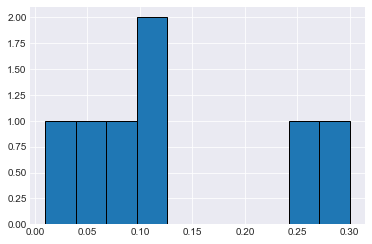

In [17]:
preds = np.array([.25, .1, .1, .09, .30, .05, .01])
temperature = 1.0 # the other parameter we can adjust

pd.Series(preds).hist(bins=10, edgecolor='black')

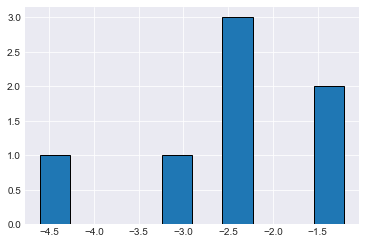

In [18]:
# This just ensures they're floats
preds = np.asarray(preds).astype('float64')

preds = np.log(preds) / temperature
pd.Series(preds).hist(bins=10, edgecolor='black')

When temperature = 1, this is just a log transform!

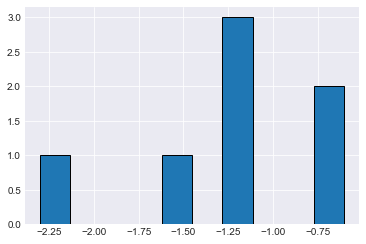

In [23]:
preds = np.array([.25, .1, .1, .09, .30, .05, .01])
temperature = 2

preds = np.log(preds) / temperature

pd.Series(preds).hist(bins=10, edgecolor='black')

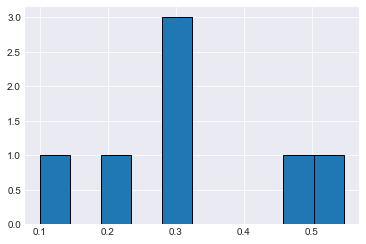

In [25]:
exp_preds = np.exp(preds)

pd.Series(exp_preds).hist(bins=10, edgecolor='black')

preds sum: 0.9999999999999999


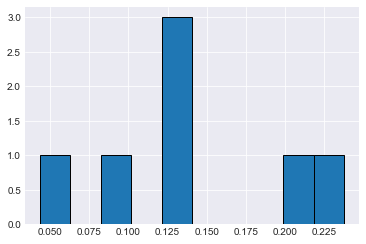

In [29]:
# This just normalizes the probability distribution
preds = exp_preds / np.sum(exp_preds)

print('preds sum:', np.sum(preds))

pd.Series(preds).hist(bins=10, edgecolor='black')

In [38]:
# Taking 1 index, from preds, one time,
# according to its probability distribution
probas = np.random.multinomial(1, preds, 1)

print('preds (rounded):', [round(i, 2) for i in preds])
print('probas:', probas)

preds (rounded): [0.22, 0.14, 0.14, 0.13, 0.24, 0.1, 0.04]
probas: [[1 0 0 0 0 0 0]]


Let's choose 1000 indices just to make sure this is working.

In [51]:
probas = np.random.multinomial(1, preds, 1000)
prob_sums = np.sum(probas, axis=0)

print('Initial Probability', '\t', 'Times Picked')
for i in range(len(preds)):
    print(round(preds[i], 2), '\t\t\t', prob_sums[i])

Initial Probability 	 Times Picked
0.22 			 217
0.14 			 132
0.14 			 118
0.13 			 143
0.24 			 257
0.1 			 84
0.04 			 49


Cool, right? `prob_sums` is just probabilistically selecting an index and the sample function returns it. Let's see it one more time just to review all its moving parts:

In [52]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [9]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    # Choose a random point in the text
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        
        # Construct a "seed sentence", from the random point, of maxlen length
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        
        # We're going to sequentially build on this empty string (400 times)
        sys.stdout.write(generated)

        for i in range(400):
            
            # This one-hot encodes the sentence we currently have
            # (Starting with the seed sentence)
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            
            # Predict the one-hot encoding we just made
            preds = model.predict(x_pred, verbose=0)[0]
            
            # Sample an index (diversity tries different temperatures)
            next_index = sample(preds, diversity)
            
            # Convert that index number to a character
            next_char = indices_char[next_index]

            # Add that character to our sentence
            generated += next_char
            
            # Shift the sentence string by 1 to include our new, predicted character
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

# Use this to print at the end of each training epoch
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


try:
    model.fit(x, y,
              batch_size=128,
              epochs=60,
              callbacks=[print_callback])
except KeyboardInterrupt:
    pass

Epoch 1/60
200192/200285 [============================>.] - ETA: 0s - loss: 1.9121  